In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Добавим директорию chapter03 в PYTHONPATH
sys.path.append(os.path.abspath(".."))

from models.linear_regression import linear_regression, predict
from utils.plotting import draw_line, plot_points, plot_errors
from utils.errors import mae, mse, rmse 
from utils.reporting import format_equation, print_prediction

## Простой подход для перемещения прямой ближе к набору точек, по одной точке за раз

Метод состоит в том, чтобы слегка повернуть и переместить прямую в направлении точки и тем самым сблизить их.  
Итак, вот четыре сценария:
| **📌 Сценарий** | **📍 Положение точки**       | **🔄 Направление вращения**      | **📤 Перемещение прямой** |
|--------------|---------------------------|-------------------------------|------------------------|
| 1            | 🔴**Над** прямой, 🟡**справа** от оси $Y$ | 🔵**Против** часовой стрелки       | ⏫Вверх                  |
| 2            | 🔴**Над** прямой, 🟣**слева** от оси $Y$  | 🟠**По** часовой стрелке           | ⏫Вверх                  |
| 3            | 🟢**Под** прямой, 🟡**справа** от оси $Y$ | 🟠**По** часовой стрелке           | ⬇️Вниз                   |
| 4            | 🟢**Под** прямой, 🟣**слева** от оси $Y$  | 🔵**Против** часовой стрелки       | ⬇️Вниз                   |

---
Уравнение прямой: $ y = m \cdot x + b $,

где
- $m$ — наклон;
- $b$ — $Y$-пересечение.

В примере с жильём использовали аналогичную нотацию:
- точка с координатами $(r, p)$ соответствует дому с $r$ комнатами и ценой $p$;
- наклон $m$ соответствует цене за комнату;
- $y$-пересечение $b$ соответствует базовой цене дома;
- прогноз $ \hat{p} = m \cdot r + b $ соответствует прогнозируемой цене дома

## Псевдокод для простого подхода

**Входные данные:**
1. линия с наклоном $m$, $Y$-пересечением $b$ и уравнением $ \hat{p} = m \cdot r + b $
2. точка с координатами $(r, p)$.

**Результат** — линия $ \hat{p} = m' \cdot r + b' $, которая ближе к точке.

---

**Процедура:**  
- Выберите два очень маленьких случайных числа и назовите их  $ \eta_1 $ и $ \eta_2 $ (греческая буква *«эта»*).

- **Сценарий 1.** Если точка находится 🔴**над** прямой и 🟡**справа** от оси $Y$, вращаем прямую 🔵**против** часовой стрелки и перемещаем ее ⏫**вверх**:
  1. ➕Добавляем $ \eta_1 $ к наклону $m$, получаем $ m' = m + \eta_1 $
  2. ➕Добавляем $ \eta_2 $ к $Y$-пересечению $b$, получаем $ b' = b + \eta_2 $

- **Сценарий 2.** Если точка находится 🔴**над** прямой и 🟣**слева** от оси $Y$, вращаем прямую 🟠**по** часовой стрелке и перемещаем ее ⏫**вверх**:
  1. ➖Вычитаем $ \eta_1 $ из наклона $m$, получаем $ m' = m - \eta_1 $  
  2. ➕Добавляем $ \eta_2 $ к $Y$-пересечению $b$, получаем $ b' = b + \eta_2 $  

- **Сценарий 3.** Если точка находится 🟢**под** прямой и 🟡**справа** от оси $Y$, вращаем прямую 🟠**по** часовой стрелке и перемещаем ее ⬇️**вниз**:
  1. ➖Вычитаем $ \eta_1 $ из наклона $m$, получаем $ m' = m - \eta_1 $  
  2. ➖Вычитаем $ \eta_2 $ из $Y$-пересечения $b$, получаем $ b' = b - \eta_2 $  

- **Сценарий 4.** Если точка находится 🟢**под** прямой и 🟣**слева** от оси $Y$, вращаем прямую 🔵**против** часовой стрелки и перемещаем ее ⬇️**вниз**:
  1. ➕Добавляем $ \eta_1 $ к наклону $m$, получаем $ m' = m + \eta_1 $  
  2. ➖Вычитаем $ \eta_2 $ из $Y$-пересечения $b$, получаем $ b' = b - \eta_2 $

**Возврат** — прямая $ \hat{p} = m' \cdot r + b' $

---

Поскольку координата $x$ — количество комнат, это число **не может быть отрицательным**.  
Таким образом, здесь важны только сценарии 1 и 3.

---

## Квадратический подход — более умный способ приблизить прямую к одной из точек

**Вывод 1: Корректировка смещения (Y-пересечения)**  
Если добавить разность $( p - \hat{p} )$ к смещению $( b )$, прямая будет двигаться к точке, так как:  
- $( p - \hat{p} > 0 $) (точка **выше** прямой) → смещение **увеличивается** (линия сдвигается вверх).  
- $( p - \hat{p} < 0 $) (точка **ниже** прямой) → смещение **уменьшается** (линия сдвигается вниз).  

Однако в машинном обучении шаги должны быть небольшими, поэтому вводится **скорость обучения** $( \eta )$:  
$$
b_{\text{новое}} = b + \eta \cdot (p - \hat{p})
$$


**Вывод 2: Корректировка наклона (веса признака)**  
Рассмотрим величину $( r \cdot (p - \hat{p}) )$:  
- **Положительна** в сценариях 1 и 4 (точка справа/слева и выше/ниже прямой).  
- **Отрицательна** в сценариях 2 и 3 (точка слева/справа и выше/ниже прямой).  

Таким образом, добавление $( \eta \cdot r \cdot (p - \hat{p}) )$ к наклону $( m )$ всегда приближает прямую к точке:  
$$
m_{\text{новое}} = m + \eta \cdot r \cdot (p - \hat{p})
$$

**Итоговые правила обновления:**
$$
\begin{cases}
m' = m + \eta \cdot r \cdot (p - \hat{p}), \\
b' = b + \eta \cdot (p - \hat{p}).
\end{cases}
$$

**Пояснение:**   
- $( \eta )$ (эта) — скорость обучения, малая константа (например, 0.01).  
- $( p - \hat{p} )$ — ошибка прогноза (разница между истинным и предсказанным значениями).  
- Множитель $( r )$ масштабирует влияние признака на корректировку.

## Псевдокод для квадратического подхода

**Входные данные:**
1. прямая с наклоном $m$, $Y$-пересечением $b$ и уравнением $ \hat{p} = m \cdot r + b $
2. точка с координатами $(r, p)$;
3. небольшое положительное значение (скорость обучения).

**Результат** — прямая $ \hat{p} = m' \cdot r + b' $, которая находится ближе к точке.

---

**Процедура:**  
- Добавляем $ \eta \cdot r \cdot (p - \hat{p}) $ к наклону $m$, получаем $ m' = m + \eta \cdot r \cdot (p - \hat{p}) $ (при этом прямая вращается).
- Добавляем $ \eta \cdot (p - \hat{p}) $ к $Y$-пересечению $b$, получаем $ b' = b + \eta \cdot (p - \hat{p}) $ (это перемещает прямую).

**Возврат** — прямая $ \hat{p} = m' \cdot r + b' $.

# Загрузка данных и построение их графика

In [3]:
# 1. Данные
features = np.array([1, 2, 3, 5, 6, 7])
labels = np.array([155, 197, 244, 356, 407, 448])

In [4]:
# 2. Обучение
trick = 'square'
error = 'rmse'

m, b, errors_list = linear_regression(features, labels, epochs=10000, trick = trick, error = error)

In [5]:
# 3. Отчётность
print("Уравнение прямой:", format_equation(m, b))
print(print_prediction(m, b, 4))  # для конкретного X = 4

Уравнение прямой: y = 50.29 * x + 99.34
Для 4 комнат → Предсказанная цена: 300.52


In [6]:
# 4. Прогнозы + метрика
predictions = np.array([predict(m, b, r) for r in features])

print(f"MAE: \t {mae(labels, predictions):.2f}")
print(f"MSE: \t {mse(labels, predictions):.2f}")
print(f"RMSE: \t {rmse(labels, predictions):.2f}")

MAE: 	 4.83
MSE: 	 24.89
RMSE: 	 4.99


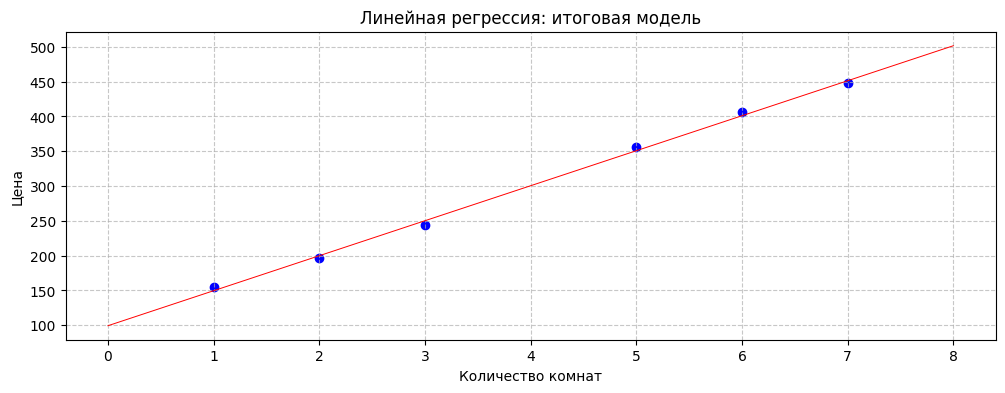

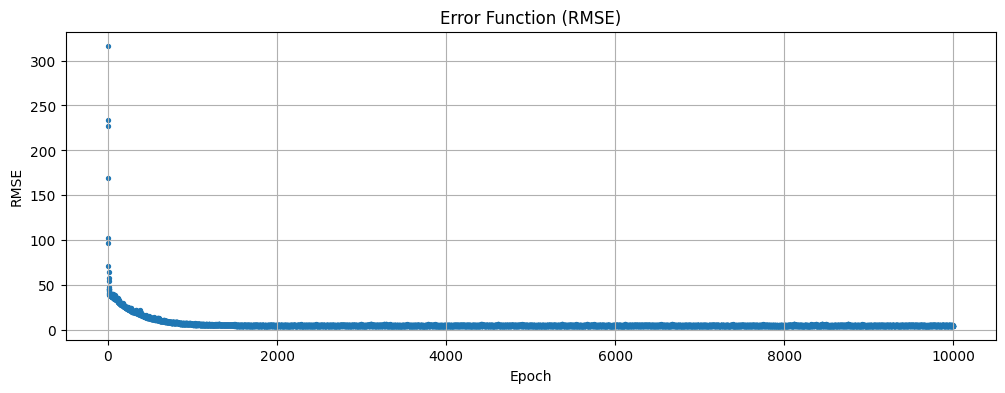

In [7]:
# 5. Визуализация
plt.figure(figsize=(12, 4))
draw_line(m, b)
plot_points(features, labels)
plt.title("Линейная регрессия: итоговая модель")
plt.show()

plt.figure(figsize=(12, 4))
plot_errors(errors_list, error)
plt.show()

# 🔁 Сравнение всех комбинаций
*Поиск оптимального сочетания метода обновления весов (trick), режима обучения (mode) и метрики ошибки (error).*

In [8]:
# 1. Данные
features = np.array([1, 2, 3, 5, 6, 7])
labels = np.array([155, 197, 244, 356, 407, 448])

In [9]:
# 2. Глобальные параметры
tricks = ['simple', 'absolute', 'square']
modes = ['sgd', 'batch', 'mini']
errors = ['mae', 'mse', 'rmse']

epochs = 3000
learning_rate = 0.01

In [10]:
# 3. Сравнение всех комбинаций

results = {}

for trick in tricks:
    results[trick] = {}
    for error in errors:
        results[trick][error] = {}
        for mode in modes:
            m, b, errors_list = linear_regression(
                features,
                labels,
                learning_rate=learning_rate,
                epochs=epochs,
                trick=trick,
                error=error,
                mode=mode,
                batch_size=2
            )
            predictions = np.array([predict(m, b, r) for r in features])
            results[trick][error][mode] = {
                'm': m,
                'b': b,
                'errors_list': errors_list,
                'mae': mae(labels, predictions),
                'mse': mse(labels, predictions),
                'rmse': rmse(labels, predictions)
            }

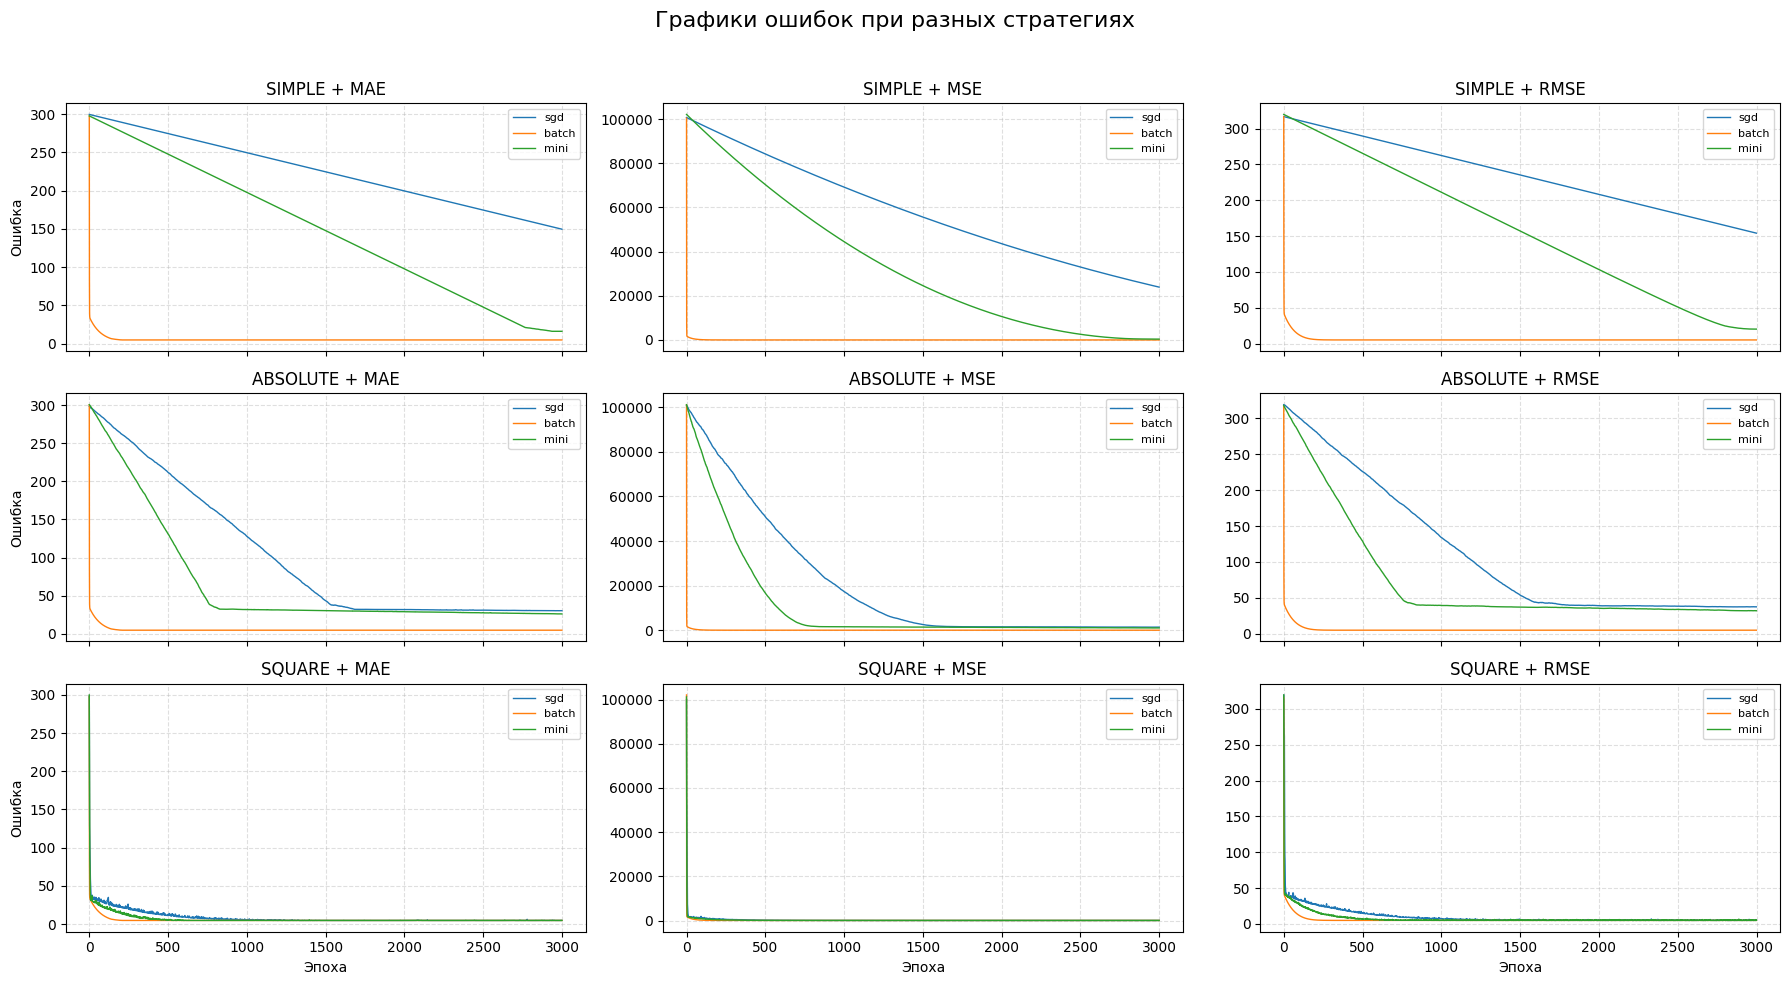

In [11]:
# 4. Визуализация ошибок (Error Curves)
fig, axs = plt.subplots(len(tricks), len(errors), figsize=(18, 10), sharex=True)#, sharey=True)
fig.suptitle("Графики ошибок при разных стратегиях", fontsize=16)

for i, trick in enumerate(tricks):
    for j, error in enumerate(errors):
        ax = axs[i, j]
        for mode in modes:
            ax.plot(results[trick][error][mode]['errors_list'], label=mode, linewidth=1)
        ax.set_title(f"{trick.upper()} + {error.upper()}")
        ax.grid(True, linestyle='--', alpha=0.4)
        if j == 0:
            ax.set_ylabel("Ошибка")
        if i == len(tricks) - 1:
            ax.set_xlabel("Эпоха")
        ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

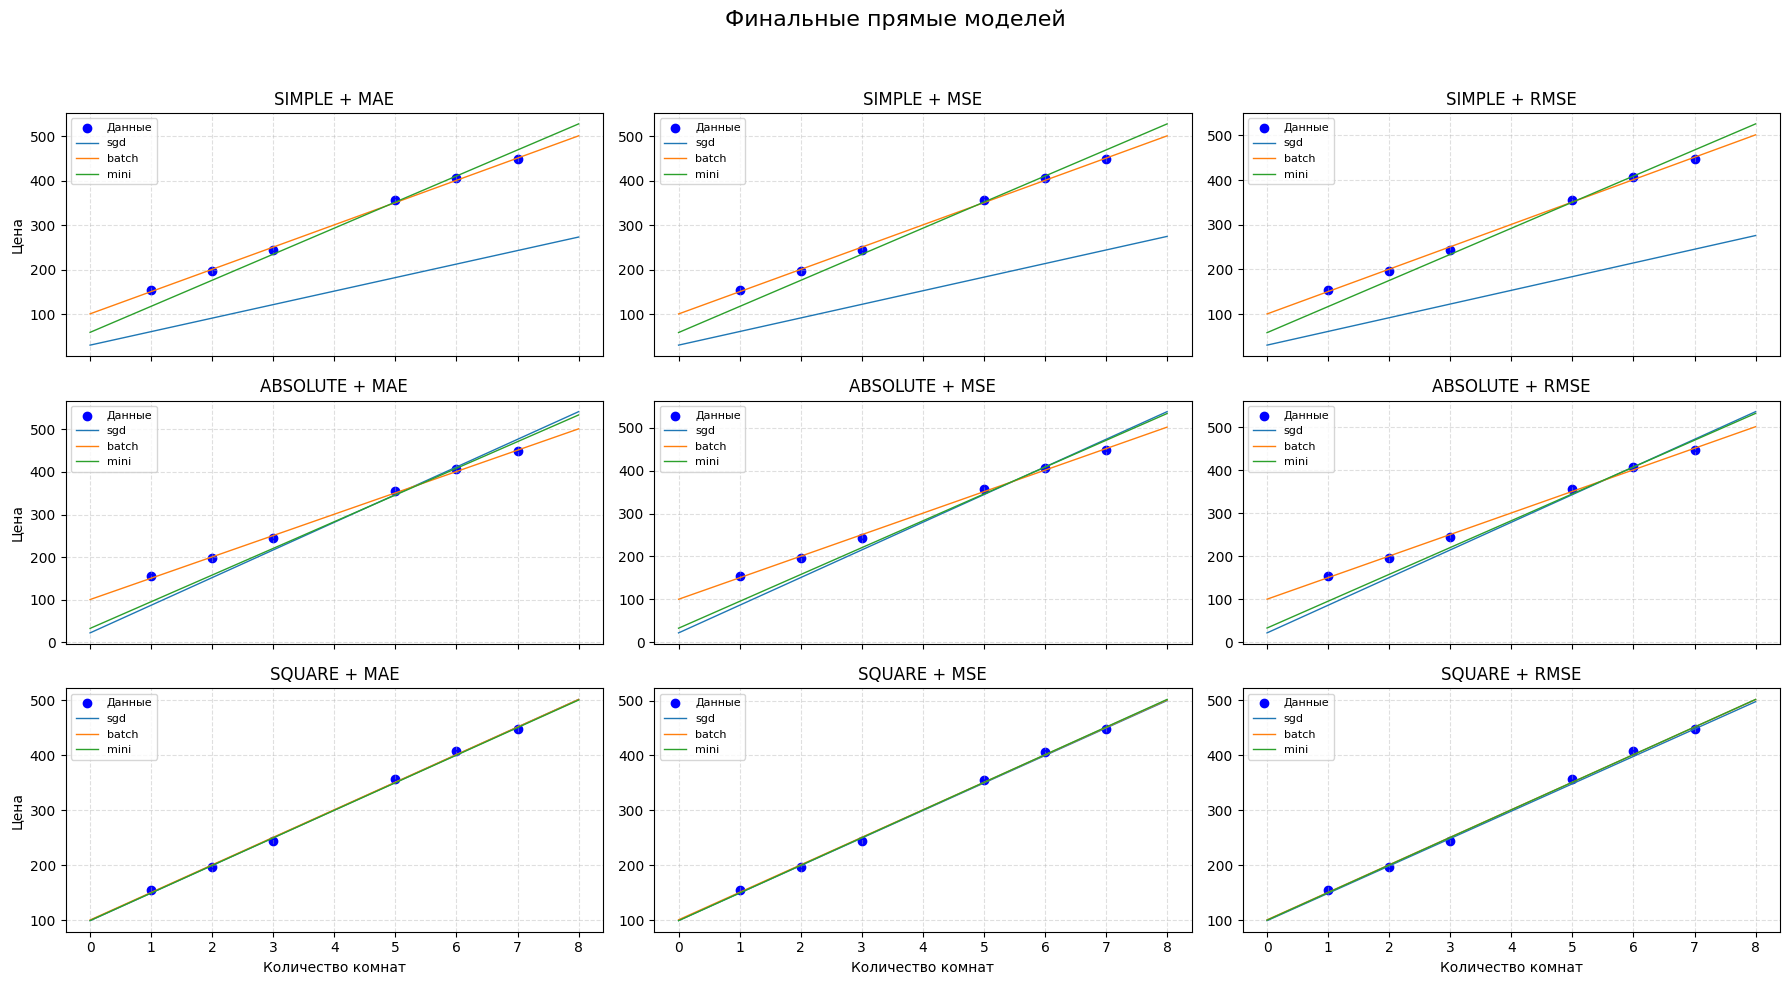

In [12]:
# 5. Визуализация моделей (Regression Lines)
fig, axs = plt.subplots(len(tricks), len(errors), figsize=(18, 10), sharex=True)
fig.suptitle("Финальные прямые моделей", fontsize=16)

x_range = np.linspace(0, 8, 100)

for i, trick in enumerate(tricks):
    for j, error in enumerate(errors):
        ax = axs[i, j] if len(tricks) > 1 else axs[j]
        
        # 1. Отобразим исходные точки
        ax.scatter(features, labels, color='blue', label='Данные')

        # 2. Отобразим прямые всех режимов
        for mode in modes:
            m = results[trick][error][mode]['m']
            b = results[trick][error][mode]['b']
            y_range = m * x_range + b
            ax.plot(x_range, y_range, label=mode, linewidth=1)

        # 3. Оформление графика
        ax.set_title(f"{trick.upper()} + {error.upper()}")
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.legend(fontsize=8)
        
        if j == 0:
            ax.set_ylabel("Цена")
        if i == len(tricks) - 1:
            ax.set_xlabel("Количество комнат")
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [13]:
# 6. Сравнительная таблица ошибок
table = []

for trick in tricks:
    for error in errors:
        for mode in modes:
            row = {
                "Trick": trick,
                "Error Metric": error,
                "Mode": mode,
                "MAE": round(results[trick][error][mode]["mae"], 2),
                "MSE": round(results[trick][error][mode]["mse"], 2),
                "RMSE": round(results[trick][error][mode]["rmse"], 2),
            }
            table.append(row)

df_results = pd.DataFrame(table)
df_results.sort_values(by=["RMSE"]).reset_index(drop=True)

,Trick,Error Metric,Mode,MAE,MSE,RMSE
0,square,rmse,mini,4.83,24.91,4.99
1,square,mse,mini,4.83,24.95,4.99
2,simple,mae,batch,4.83,25.03,5.00
3,simple,mse,batch,4.83,25.03,5.00
4,absolute,mse,batch,4.83,25.03,5.00
5,square,mse,batch,4.83,25.03,5.00
6,simple,rmse,batch,4.83,25.03,5.00
7,absolute,mae,batch,4.83,25.03,5.00
8,absolute,rmse,batch,4.83,25.03,5.00
9,square,rmse,batch,4.83,25.03,5.00


In [14]:
df_results.to_excel('results.xlsx')

# 📊 Общий финальный вывод:  
**Лучшее сочетание:**
 - ✅ **Trick:** square  
 - ✅ **Mode:** batch (или mini-batch)  
 - ✅ **Error metric:** неважно (mae / mse / rmse схожи при хорошем обучении)  

**Общая тенденция:**
 - square $> ($ absolute $≈$ simple $)$
 - batch $>$ mini-batch $>$ sgd

# Линейная регрессия с использованием библиотеки Scikit-Learn

In [15]:
# Импортируем класс LinearRegression из библиотеки sklearn
from sklearn.linear_model import LinearRegression

In [16]:
# Преобразуем массив признаков (features) в двумерный формат.
# Scikit-Learn требует, чтобы входные признаки были в виде матрицы (n образцов × m признаков),
# даже если у нас всего один признак.
features_reshaped = features.reshape(-1, 1)

In [17]:
# Создаём объект модели линейной регрессии
model = LinearRegression()

# Обучаем модель на наших данных (признаки + правильные ответы)
# Модель подберёт такие коэффициенты, чтобы минимизировать среднеквадратичную ошибку
model.fit(features_reshaped, labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [18]:
# Выводим коэффициент (наклон прямой) и свободный член (сдвиг по оси Y)
print("Коэффициент (наклон прямой):", model.coef_)
print("Свободный член (пересечение с осью Y):", model.intercept_)

Коэффициент (наклон прямой): [50.39285714]
Свободный член (пересечение с осью Y): 99.59523809523819


In [19]:
# Предсказываем результат для нового значения признака — например, если "количество комнат" равно 4
new_point = np.array([[4]])  # Вход должен быть двумерным массивом: [[4]]
predicted_label = model.predict(new_point)
print("Предсказанная цена для признака = 4:", predicted_label)

Предсказанная цена для признака = 4: [301.16666667]


## Визуализация

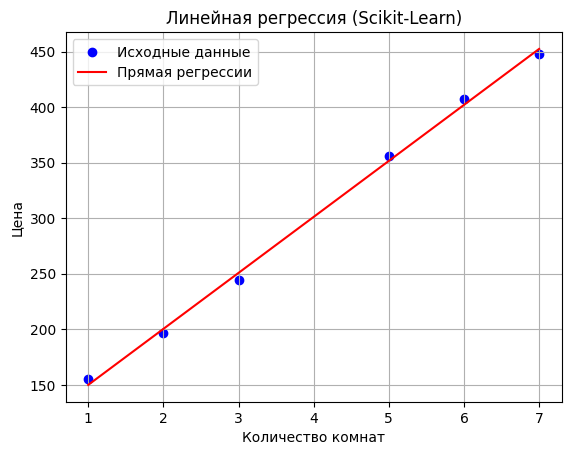

In [20]:
# Получаем предсказанные значения модели для всех исходных признаков (features)
# Это нужно, чтобы нарисовать линию регрессии
predicted_labels = model.predict(features_reshaped)

# Строим исходные точки (настоящие данные)
plt.scatter(features, labels, color='blue', label='Исходные данные')

# Строим саму прямую регрессии по предсказанным значениям
plt.plot(features, predicted_labels, color='red', label='Прямая регрессии')

# Добавляем подписи осей и заголовок
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Линейная регрессия (Scikit-Learn)')

# Добавляем легенду, чтобы отличать точки от линии
plt.legend()

# Включаем сетку на графике
plt.grid(True)

# Показываем финальный график
plt.show()